# LIDAR Data exploration with LidR package

In [1]:
options(repr.plot.width = 10, repr.plot.height = 8)

In [2]:
library(lidR)
library(sf)
library(tidyverse)
library(ggplot2)
library(terra)

LidR is an open-source R package for manipulating and visualizing airborne laser scanning (ALS) data with an emphasis on research & development for forestry and ecology applications. We chose this package since it worked naturally with LAS file type data and was used in a previous grape yield estimation study. This notebook goes through the step-by-step process of how we isolated candidate grape clusters using RGB filtering.

## Data loading

To load in the data set, you have run the readLAS function with the relative path to your las file.  

In [ ]:
riesling <- readLAS("../../../data/Georeferenced/CodyKrest9_4_24_riesling_chest1_ref6.las")

### Las file information
Once you have a LAS object created, you can view the file information and get relavent statitics of your point cloud by uing the `summary` function. Some of the key information that we are looking for are the Offests for the XYZ components, the point cloud density, the area of the field, memory usage, and number of point clouds. All of the information is displayed below for this example. 

<div style="border-left: 5px solid #0078D4; padding: 10px; background-color: #f0f8ff;">
    <strong>Note:</strong> This approach has not been sucessfull and was soon abandoned due to lack of results. We encourage to use this guide as a stepping stone to other more complicated approaches that we may introduce in ohter notebooks. 
</div>


In [113]:
summary(riesling)

class        : LAS (v1.4 format 7)
memory       : 1.7 Gb 
extent       : 12731583, 12731767, 277534.4, 277855.3 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / Michigan South (ft) 
area         : 34476 ft²
points       : 31.12 million points
density      : 902.57 points/ft²
File signature:           LASF 
File source ID:           0 
Global encoding:
 - GPS Time Type: GPS Week Time 
 - Synthetic Return Numbers: no 
 - Well Know Text: CRS is WKT 
 - Aggregate Model: false 
Project ID - GUID:        00000000-0000-0000-0000-000000000000 
Version:                  1.4
System identifier:        libLAS 
Generating software:      QT Modeler 8.4.1946 
File creation d/y:        9/2025
header size:              375 
Offset to point data:     5431 
Num. var. length record:  1 
Point data format:        7 
Point data record length: 36 
Num. of point records:    31117012 
Num. of points by return: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Scale factor X Y Z:       1e-04 1e-04 1e-04 
Offset X Y Z:       

## Data Cleaning

To clean the point cloud, we are following the steps taken by the research paper of Jorge Torres-Sánchez et al.:

1. Decimation: We decimate the point cloud based on the overall average density. We used a 32.8 ft² grid, which is twice the size of that used in the paper (5 meters).
2. After the point cloud decimation, we removed the ground using the Cloth Simulation Filtering (CSF) algorithm. The CSF simulates artificial cloths that attach themselves to the ground. Using the interaction of the cloth with the ground, the cloth nodes are used to generate a model of the terrain surface.
3. After obtaining a ground classification, we rasterized the terrain and normalized the height of our point cloud. The reason we do this is to create filtering conditions that allow us to separate areas where no grape clusters can be found. Generally speaking, based on literature, grapes like Riesling or Cabernet Franc are grown in a Vertical Shoot Positioning (VSP) system. Thus, we can expect grapes to be found between heights of 3 ft and 7 ft.
4. Filtering was the last step. We filtered out ground points, heights of unlikely grape-growing regions, and the color of the specific grape. The results can be seen by writing the lidR object to a file and viewing it in CloudCompare.

### Cloud point decimation

In [ ]:
grid_size_ft <- 10 * 3.28084  # 16.4042 feet
density_raster <- grid_density(riesling, res = grid_size_ft)
overall_avg_density <- mean(values(density_raster), na.rm = TRUE)

thinned <- decimate_points(riesling,homogenize(overall_avg_density, res = 1, use_pulse = FALSE))

### CSF algorithm

In [33]:
csf_params <- csf(
  class_threshold = 0.5,  
  cloth_resolution = 1.0,  
  rigidness = 3,          
  time_step = 0.65,        
  iterations = 500       
)

las_ground <- classify_ground(thinned, csf_params)

### Rasterize and normalize Height

In [25]:
dem <- rasterize_terrain(las_ground, res = 1, algorithm = tin())

In [ ]:
las_norm <- normalize_height(las_ground, dem)#use_class = las_ground@data$Classification, algorithm = tin()) 

### Filtering

In [ ]:
las_filtered <- filter_poi(las_norm, Classification ==0 & Z >= 3 & Z <= 7 )

In [ ]:
las_riesling <- filter_poi(las_filtered, 
                           R > 120 & 
                           G > 70 & 
                           B < 100 & 
                           G > R)

### Plots and Visuals of point cloud

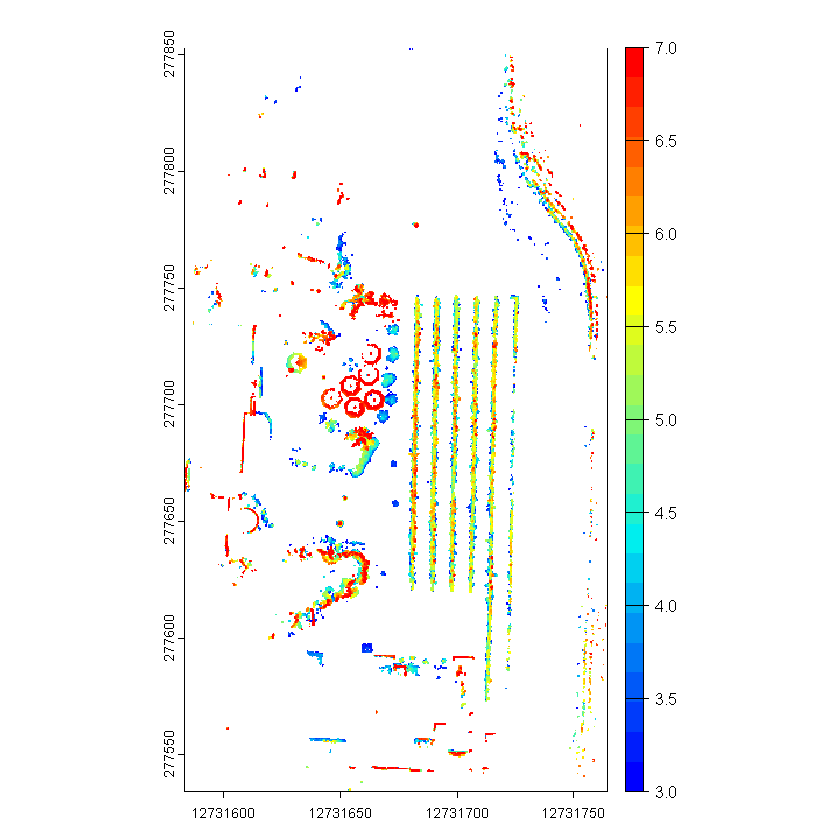

In [74]:
col <- height.colors(25)
plot(cbm, col=col)

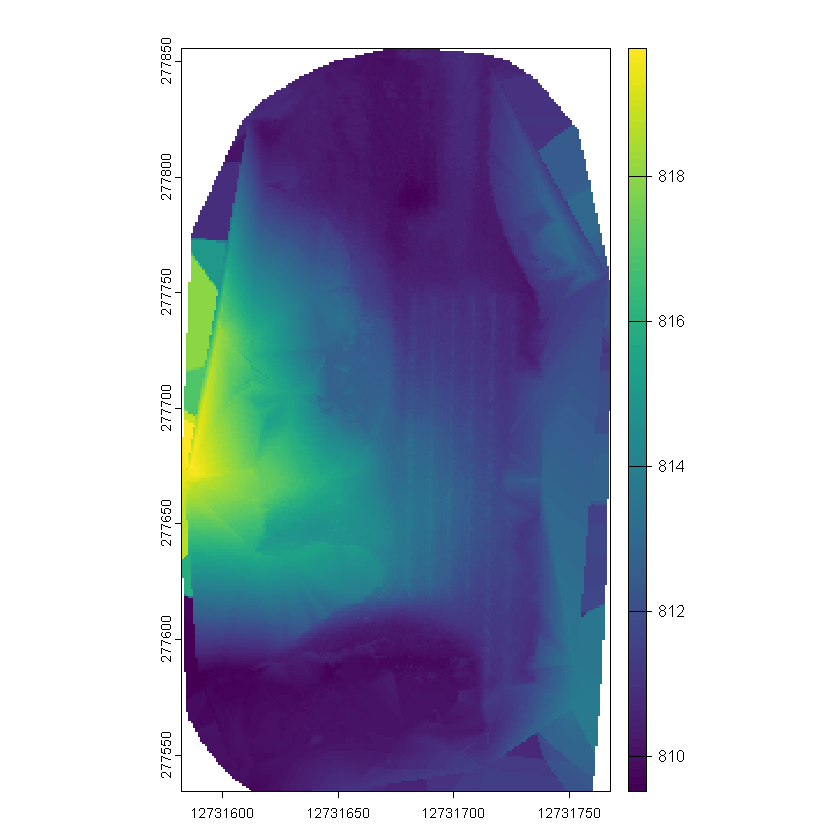

In [40]:
plot(dem)

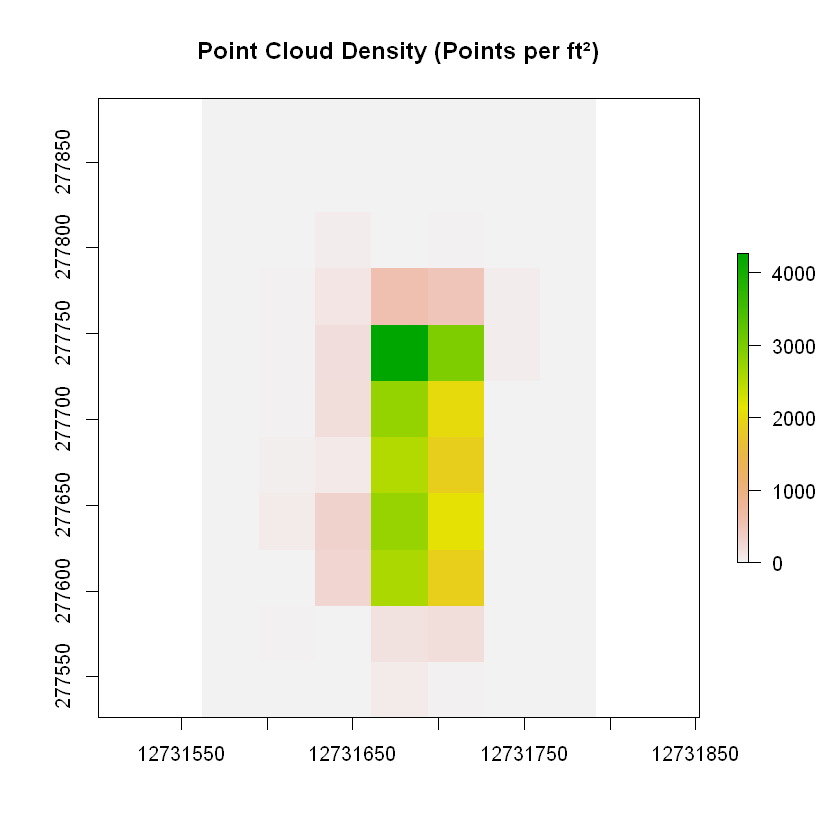

In [28]:
plot(density_raster, main = "Point Cloud Density (Points per ft²)")

In [93]:
p1 <- c(12731582.5, 277534.4)  
p2 <- c(12731767.5, 277855.3)
las_tr <- clip_transect(las_norm, p1, p2, width = 5, xz = TRUE)

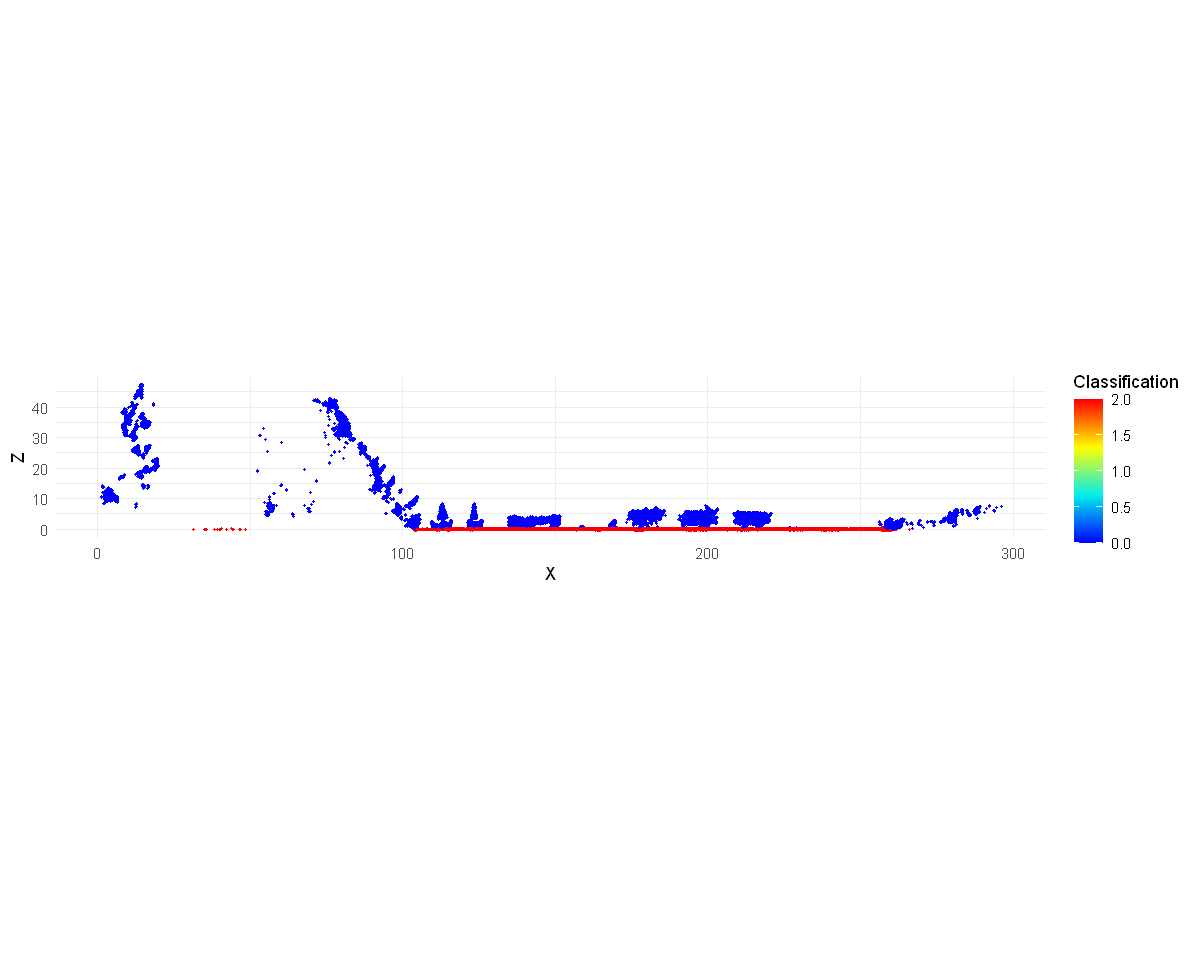

In [97]:
ggplot(payload(las_tr), aes(X,Z, color = Classification)) + 
  geom_point(size = 0.5) + 
  coord_equal() + 
  theme_minimal() +
  scale_color_gradientn(colours = height.colors(50))